# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json

from scipy.stats import linregress
from citipy import citipy
from pprint import pprint

from api_keys import weather_api_key
from api_keys import g_key

# Set output file path
output_file = "../output_files/cities_weather.csv"

# Set range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# Creat empty lists for lat_lgn and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Find the closest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
# If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

print(f"There's %s cities to poll for weather." % len(cities))

There's 635 cities to poll for weather


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
# Setup Query URL
base_url = "http://api.openweathermap.org/data/2.5/weather?appid="
api_key = weather_api_key
units = "imperial"
query_url = f"{base_url}{api_key}&units={units}&q="

In [4]:
# Create dict ro stre data from API calls
city_weather_data = {"City": [],
                     "Lat": [],
                     "Lng": [],
                     "Max Temp": [],
                     "Humidity": [],
                     "Cloudiness": [],
                     "Wind Speed": [],
                     "Country": [],
                     "Date": []}

# A loop that repeats an api call with dynamic endpoints then adds data retrieved from each api call into "city_data" dictionary
for i, city in enumerate(cities):
    city = requests.get(query_url + cities[i].replace(" ","&")).json()

    try:
        print(f"Processing city " + str(i) + ": " + city["name"])

        city_weather_data["City"].append(city["name"])
        city_weather_data["Lat"].append(city["coord"]["lat"])
        city_weather_data["Lng"].append(city["coord"]["lon"])
        city_weather_data["Max Temp"].append(city["main"]["temp_max"])
        city_weather_data["Humidity"].append(city["main"]["humidity"])
        city_weather_data["Cloudiness"].append(city["clouds"]["all"])
        city_weather_data["Wind Speed"].append(city["wind"]["speed"])
        city_weather_data["Country"].append(city["sys"]["country"])
        city_weather_data["Date"].append(city["dt"])

    except:
        print(f"Data retrieve failure. Skipping city instance...")
        pass
print("Data retrieval is complete.")

Processing city 0: Rawson
Processing city 1: Rikitea
Processing city 2: Phan
Processing city 3: Castro
Processing city 4: Lively
Processing city 5: Albany
Processing city 6: Sitka
Processing city 7: Busselton
Processing city 8: Grindavik
Processing city 9: Bengkulu
Processing city 10: Bluff
Processing city 11: Baruun-Urt
Processing city 12: Berlevåg
Processing city 13: Lerwick
Processing city 14: Lompoc
Processing city 15: Esperance
Processing city 16: Narsaq
Processing city 17: Mataura
Processing city 18: Tuktoyaktuk
Processing city 19: Thompson
Processing city 20: Provideniya
Data retrieve failure. Skipping city instance...
Processing city 22: Kapaa
Processing city 23: Atuona
Processing city 24: Tallahassee
Processing city 25: Ushuaia
Processing city 26: Mahébourg
Processing city 27: Maturin
Processing city 28: Aktobe
Processing city 29: Sobolevo
Processing city 30: Punta
Processing city 31: Cidreira
Data retrieve failure. Skipping city instance...
Data retrieve failure. Skipping cit

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [12]:
city_weather_df = pd.DataFrame(city_weather_data)
city_weather_df.to_csv(output_file)
print(city_weather_df.head())

city_retrieved = city_weather_df["City"].count()
print(f"There's %s cities data retrieved out of {len(cities)} cities." % city_retrieved)

success_rate = round((city_retrieved / len(cities) * 100),2)
print(f"Success rate is: %s" % success_rate  + "%.")

      City      Lat       Lng  Max Temp  Humidity  Cloudiness  Wind Speed  \
0   Rawson -43.3002  -65.1023     59.05        58         100       27.18   
1  Rikitea -23.1203 -134.9692     74.07        73          95       12.53   
2     Phan  19.5539   99.7405     83.86        61          44        4.43   
3   Castro -24.7911  -50.0119     55.87        42         100        1.36   
4   Lively  46.4334  -81.1498     59.81        92          90        4.54   

  Country        Date  
0      AR  1631338727  
1      PF  1631338680  
2      TH  1631338729  
3      BR  1631338730  
4      CA  1631338730  
There's 565 cities data retrieved out of 635 cities.
Success rate is: 88.98%.


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [7]:
test_stats = city_weather_df["Humidity"].describe()
print(test_stats)
print(f"Inspection result showing the maximum humidity value is 100%. Number of cities to analyze remains the same.")

count    565.000000
mean      68.847788
std       21.739468
min        8.000000
25%       57.000000
50%       73.000000
75%       86.000000
max      100.000000
Name: Humidity, dtype: float64
Inspection result showing the maximum humidity value is 100%. Number of cities to analyze remains the same.


In [ ]:
#  Get the indices of cities that have humidity over 100%.

In [ ]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [218]:
# Creates variables for relevant table columns
lat = city_weather_df["Lat"]
max_temp = city_weather_df["Max Temp"]
humidity = city_weather_df["Humidity"]
cloudiness = city_weather_df["Cloudiness"]
wind_speed = city_weather_df["Wind Speed"]

## Latitude vs. Temperature Plot

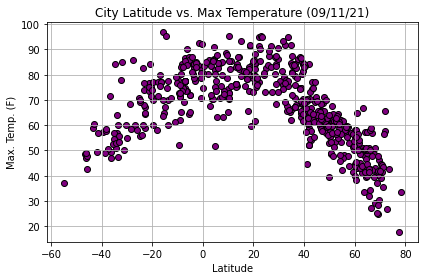

In [219]:
# Plotting data into graph
plt.scatter(lat, max_temp, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")

plt.title("City Latitude vs. Max Temperature (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Max. Temp. (F)")
plt.grid(True)
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/Lat_Temp.png")


## Latitude vs. Humidity Plot

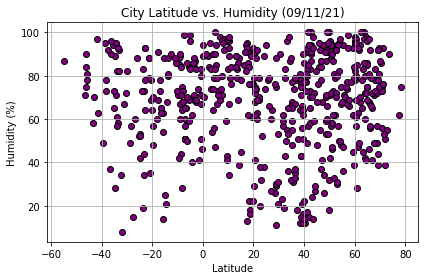

In [220]:
# Plotting data into graph
plt.scatter(lat, humidity, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")

plt.title("City Latitude vs. Humidity (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.grid(True)
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/Lat_Humid.png")

## Latitude vs. Cloudiness Plot

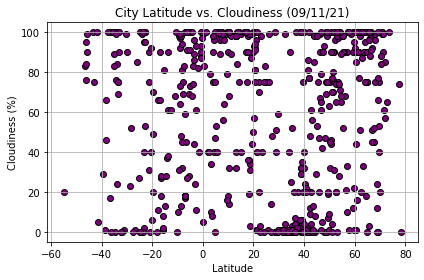

In [221]:
# Plotting data into graph
plt.scatter(lat, cloudiness, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")

plt.title("City Latitude vs. Cloudiness (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.grid(True)
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/Lat_Cloud.png")

## Latitude vs. Wind Speed Plot

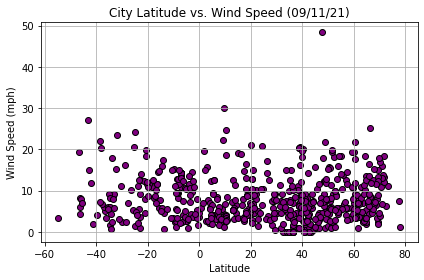

In [222]:
# Plotting data into graph
plt.scatter(lat, wind_speed, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")

plt.title("City Latitude vs. Wind Speed (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.grid(True)
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/Lat_Wind.png")

## Linear Regression

# Define plotting function
def plot_linear_regression(xdata, ydata, xlbl, ylbl, lblpos):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(xdata, ydata)
    print(f"The r-squared is: {rvalue}")
    regress_values = xdata * slope + intercept
    line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

    plt.scatter(xdata, ydata, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
    plt.plot(xdata,regress_values, "orange")
    plt.annotate(line_eq, lblpos, fontsize = 15, color = "orange")
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)

In [223]:
# Create Northern and Southern Hemisphere DataFrames
northern_hemisphere = city_weather_df.loc[city_weather_df["Lat"] >= 0.0]
northern_hemisphere.reset_index(inplace = True)

southern_hemisphere = city_weather_df.loc[city_weather_df["Lat"] < 0.0]
southern_hemisphere.reset_index(inplace = True)

print(northern_hemisphere.head())
print(southern_hemisphere.head())

   index       City      Lat       Lng  Max Temp  Humidity  Cloudiness  \
0      2       Phan  19.5539   99.7405     83.86        61          44   
1      4     Lively  46.4334  -81.1498     59.81        92          90   
2      5     Albany  42.6001  -73.9662     54.30        90           4   
3      6      Sitka  57.0531 -135.3300     57.09        77          90   
4      8  Grindavik  63.8424  -22.4338     48.15       100          90   

   Wind Speed Country        Date  
0        4.43      TH  1631338729  
1        4.54      CA  1631338730  
2        4.27      US  1631338731  
3       12.66      US  1631338732  
4        6.91      IS  1631338734  
   index       City      Lat       Lng  Max Temp  Humidity  Cloudiness  \
0      0     Rawson -43.3002  -65.1023     59.05        58         100   
1      1    Rikitea -23.1203 -134.9692     74.07        73          95   
2      3     Castro -24.7911  -50.0119     55.87        42         100   
3      7  Busselton -33.6500  115.3333     

In [224]:
# Creates variables for relevant table columns
nlat = northern_hemisphere["Lat"]
nmax_temp = northern_hemisphere["Max Temp"]
nhumidity = northern_hemisphere["Humidity"]
ncloudiness = northern_hemisphere["Cloudiness"]
nwind_speed = northern_hemisphere["Wind Speed"]

slat = southern_hemisphere["Lat"]
smax_temp = southern_hemisphere["Max Temp"]
shumidity = southern_hemisphere["Humidity"]
scloudiness = southern_hemisphere["Cloudiness"]
swind_speed = southern_hemisphere["Wind Speed"]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

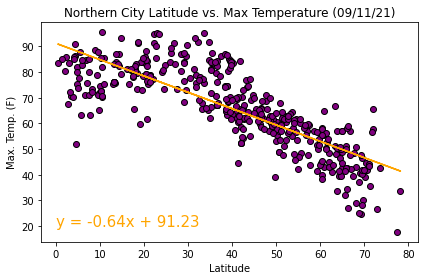

In [225]:
# Create Scatter Plot for Northern Hemisphere - Max Temp vs. Latitude Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(nlat, nmax_temp)
regress_values = nlat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(nlat, nmax_temp, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
plt.title("Northern City Latitude vs. Max Temperature (%s)" % time.strftime("%x"))
plt.plot(nlat, regress_values, "orange")
plt.annotate(line_eq, (0, 20), fontsize = 15, color = "orange")

plt.ylabel("Max. Temp. (F)")
plt.xlabel("Latitude")
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/NLat_Temp.png")

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

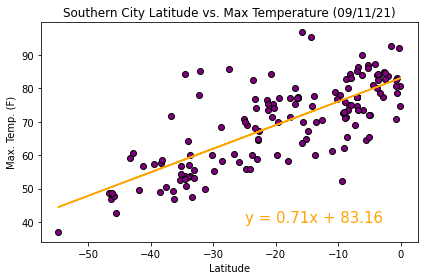

In [226]:
# Create Scatter Plot for Southern Hemisphere - Max Temp vs. Latitude Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(slat, smax_temp)
regress_values = slat * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(slat, smax_temp, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
plt.title("Southern City Latitude vs. Max Temperature (%s)" % time.strftime("%x"))
plt.plot(slat, regress_values, "orange")
plt.annotate(line_eq, (-25, 40),fontsize = 15, color="orange")

plt.ylabel("Max. Temp. (F)")
plt.xlabel("Latitude")
plt.tight_layout()

plt.savefig("../output_files/SLat_Temp.png")

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

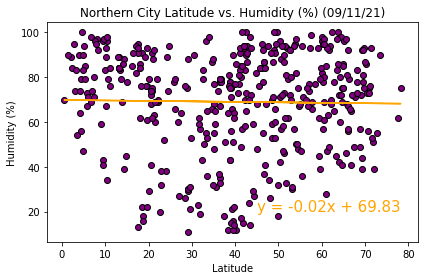

In [227]:
# Create Scatter Plot for Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(nlat, nhumidity)
regress_values = nlat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(nlat, nhumidity, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
plt.title("Northern City Latitude vs. Humidity (%%) (%s)" % time.strftime("%x"))
plt.plot(nlat, regress_values, "orange")
plt.annotate(line_eq, (45, 20), fontsize = 15, color = "orange")

plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/NLat_Humid.png")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

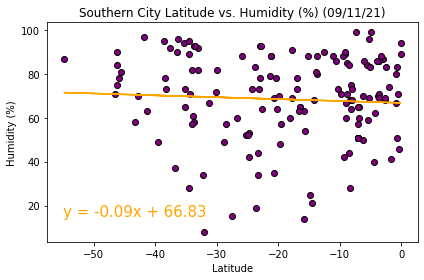

In [228]:
# Create Scatter Plot for Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(slat, shumidity)
regress_values = slat * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(slat, shumidity, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
plt.title("Southern City Latitude vs. Humidity (%%) (%s)" % time.strftime("%x"))
plt.plot(slat, regress_values, "orange")
plt.annotate(line_eq, (-55, 15),fontsize = 15, color="orange")

plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")
plt.tight_layout()

# Save grpah as PNG
plt.savefig("../output_files/SLat_Humid.png")

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

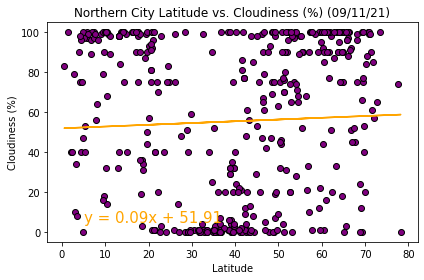

In [229]:
# Create Scatter Plot for Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(nlat, ncloudiness)
regress_values = nlat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(nlat, ncloudiness, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
plt.title("Northern City Latitude vs. Cloudiness (%%) (%s)" % time.strftime("%x"))
plt.plot(nlat, regress_values, "orange")
plt.annotate(line_eq, (5, 5), fontsize = 15, color = "orange")

plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/NLat_Cloud.png")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

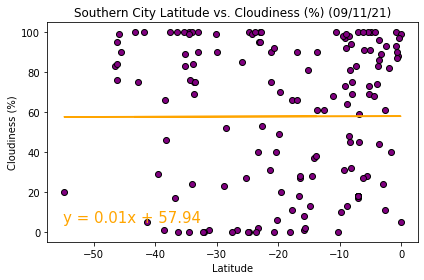

In [230]:
# Create Scatter Plot for Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(slat, scloudiness)
regress_values = slat * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(slat, scloudiness, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
plt.title("Southern City Latitude vs. Cloudiness (%%) (%s)" % time.strftime("%x"))
plt.plot(slat, regress_values, "orange")
plt.annotate(line_eq, (-55, 5),fontsize = 15, color="orange")

plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/SLat_Cloud.png")

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

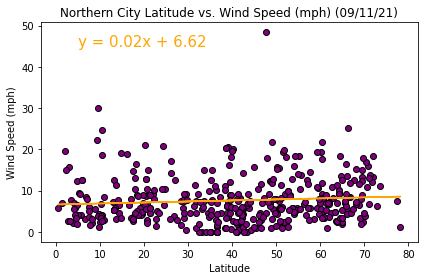

In [231]:
# Create Scatter Plot for Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(nlat, nwind_speed)
regress_values = nlat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(nlat, nwind_speed, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
plt.title("Northern City Latitude vs. Wind Speed (mph) (%s)" % time.strftime("%x"))
plt.plot(nlat, regress_values, "orange")
plt.annotate(line_eq, (5, 45), fontsize = 15, color = "orange")

plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude")
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/NLat_Wind.png")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

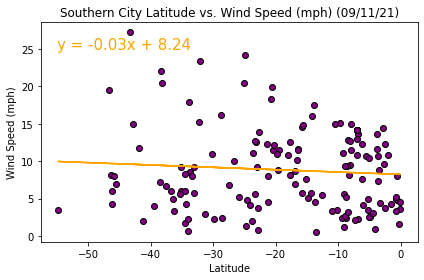

In [232]:
# Create Scatter Plot for Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(slat, swind_speed)
regress_values = slat * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(slat, swind_speed, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
plt.title("Southern City Latitude vs. Wind Speed (mph) (%s)" % time.strftime("%x"))
plt.plot(slat, regress_values, "orange")
plt.annotate(line_eq, (-55, 25), fontsize = 15, color="orange")

plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude")
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/SLat_Wind.png")